In [2]:
%pylab inline
%precision 3

%run com/saldubatech/analysis/db_access.py
%run com/saldubatech/analysis/graphs.py

table_name = 'm_m_1_c'

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
ds = data_source(table_name)

records = ds.run_query("select max(ts), min(ts), count(evid) from "+table_name+" where ev_type = 'New'")
bounds = records[0]
counts = bounds[2]
time_start = bounds[1]
time_end = bounds[0]
time_span = time_end - time_start

{'count':counts, 'start':time_start, 'end':time_end, 'span':time_span}

{'count': 100106, 'start': 0, 'end': 9999894, 'span': 9999894}

### Compute the total cycle time for jobs. Guaranteed there is only one arrival and one departure per job

{'mean': 199.79060985964736, 'std': 142.25563976870947}

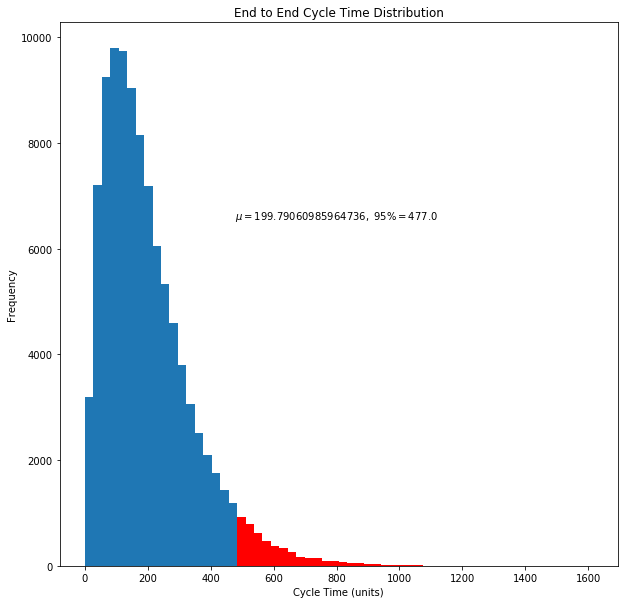

In [5]:
ds = data_source(table_name)

query = """select arr.evid as arr_evid, dep.evid as dep_evid, arr.load_id as load_id,
    arr.ts as ar_ts, dep.ts as dep_ts, dep.ts - arr.ts as ct 
from 
	"""+table_name+""" as arr
	join """+table_name+""" as dep on dep.load_id = arr.load_id
where arr.ev_type = 'New' and dep.ev_type = 'End'"""
columns = ['arr_evid','dep_evid', 'load_id', 'arr_ts', 'dep_ts', 'ct']
total_ct = ds.get_data_from_query(query, columns, indexes = "load_id")
ds.close()

h_end_to_end_ct = decorated_histogram('End to End Cycle Time Distribution', 'Cycle Time (units)', total_ct['ct'], bins=60)

{'mean':total_ct['ct'].mean(), 'std':total_ct['ct'].std()}

### Compute the Processing time at a node/step

Note that the table is indexed by the node_id/step_id and job_id, so for "multi-station", it is trivial to separate them into their own statistics.

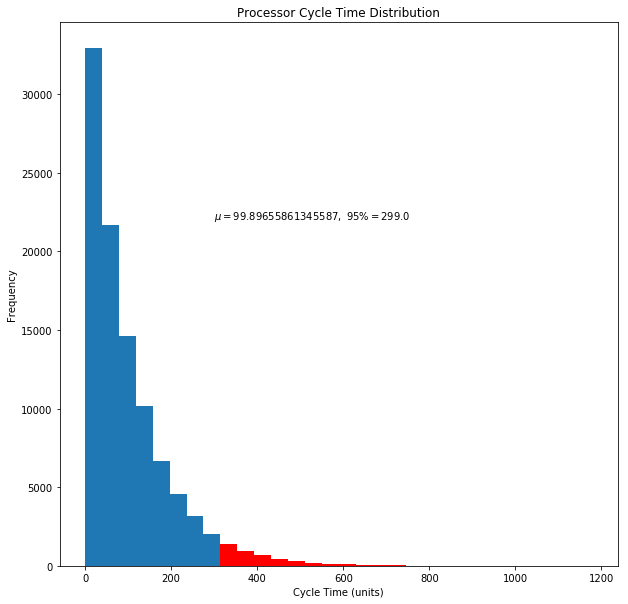

In [6]:
query="""select arr.evid as arr_id, dep.evid as dep_id, arr.station_id as node_id
, arr.load_id as job_id, arr.ts as ar_ts, dep.ts as dep_ts, dep.ts - arr.ts as pt 
from 
	"""+table_name+""" as arr
	join """+table_name+""" as dep on dep.load_id = arr.load_id and dep.station_id = arr.station_id
where arr.ev_type = 'Start' and dep.ev_type = 'Complete' and arr.station_id = 'MM1_Simulation_Source'"""
columns = ['arr_id','dep_id', 'node_id', 'job_id', 'arr_ts', 'dep_ts', 'pt']
ds = data_source(table_name)
node_pt = ds.get_data_from_query(query, columns, indexes="job_id")
ds.close()

h = decorated_histogram('Processor Cycle Time Distribution', 'Cycle Time (units)', node_pt['pt'])

   ### Compute inter-arrival time for a set of homogeneous events.

(99.89692719571646, 100.34298196434901)

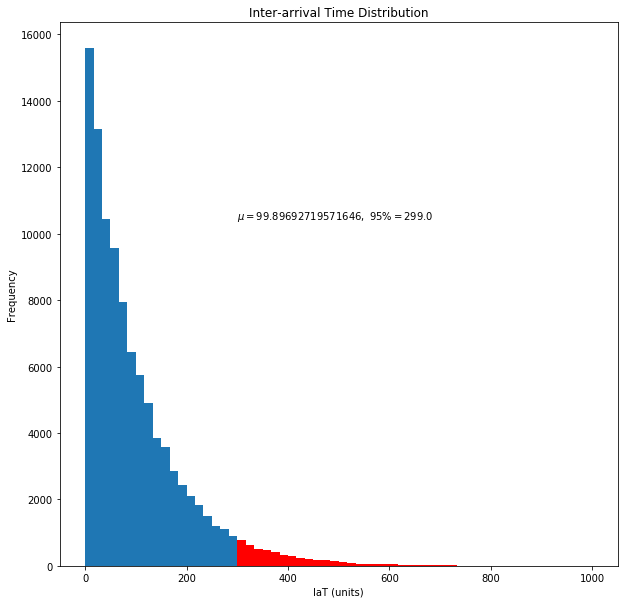

In [8]:
# The only requirement is the ts and that all events are from the sames origin, filtering can be done in SQL or pandas
query= """select arr.load_id as load_id, arr.ts as ar_ts from """+table_name+""" as arr 
where arr.ev_type = 'Depart' and arr.station_id = 'MM1_Simulation_Source'
 order by arr.ts, arr.load_id asc"""

columns=['load_id', 'arr_ts']
ds = data_source(table_name)
ev_str = ds.get_data_from_query(query, columns, indexes='load_id')
ds.close()
ev_str['p_ts'] = ev_str['arr_ts'].shift(1)

ev_str['elapsed'] = ev_str['arr_ts']-ev_str['p_ts']

iat = ev_str['elapsed'][1:]

h = decorated_histogram('Inter-arrival Time Distribution', 'IaT (units)', iat, bins=60, range=(0,1000))

ev_str['elapsed'].mean(), ev_str['elapsed'].std()


### IAT from SQL -- VERY COMPUTE INTENSIVE

In [7]:
query = """select first.arr_id as first_id, second.arr_id as second_id, second.ar_ts as second_dep, first.ar_ts as first_dep, second.ar_ts - first.ar_ts as diff from (select row_number() over (order by arr.ts) as rn, arr.load_id as arr_id, arr.load_id as load_id, arr.ts as ar_ts from  m_m_1_b as arr 
where arr.ev_type = 'Depart' and arr.station_id = 'MM1_Simulation_Source'
 order by arr.ts asc) as first
 join (select row_number() over (order by arr.ts) as rn, arr.load_id as arr_id, arr.load_id as load_id, arr.ts as ar_ts from  m_m_1_b as arr 
where arr.ev_type = 'Depart' and arr.station_id = 'MM1_Simulation_Source'
 order by arr.ts asc) as second on first.rn = second.rn - 1
"""
columns = ['first_id', 'second_id','second_dep', 'first_dep', 'diff']
ds = data_source(table_name)
ev_str = ds.get_data_from_query(query, columns, indexes='first_id')
ds.close()

ev_str['diff'].mean(), ev_str['diff'].std()



(98.8256529859965, 99.11290247265254)

### Arrival Throughput

99.897

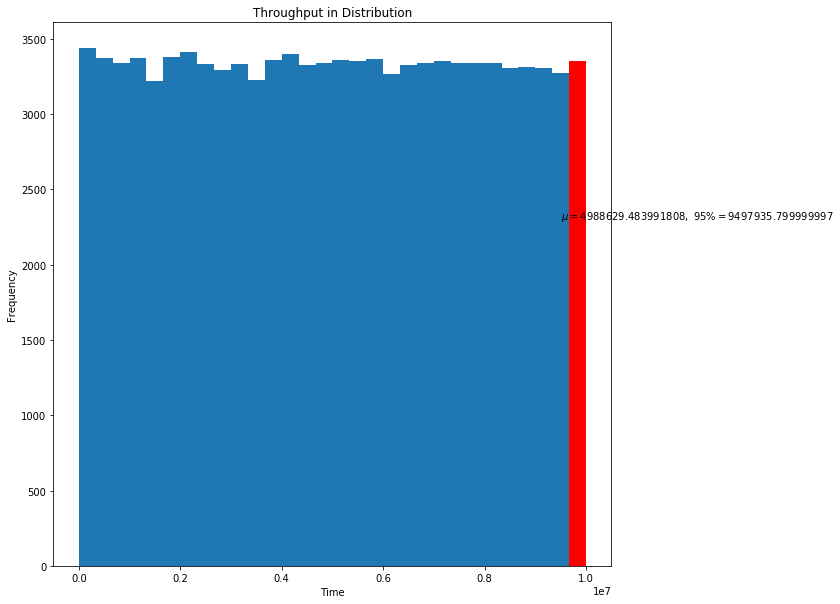

In [10]:
ds = data_source(table_name)

query= """select arr.load_id as load_id, arr.ts as ar_ts from  """+table_name+""" as arr 
where arr.ev_type = 'Depart' and arr.station_id = 'MM1_Simulation_Source'
 order by arr.ts asc"""

columns=['load_id', 'arr_ts']

ev_str = ds.get_data_from_query(query, columns, indexes='load_id')
         
ds.close()
         
h = decorated_histogram('Throughput in Distribution', 'Time', ev_str['arr_ts'])

max(ev_str['arr_ts'])/len(ev_str['arr_ts'])

### Strict Processing times in the Source following exponential distribution

(99.89655861345587, 100.34254853508578)

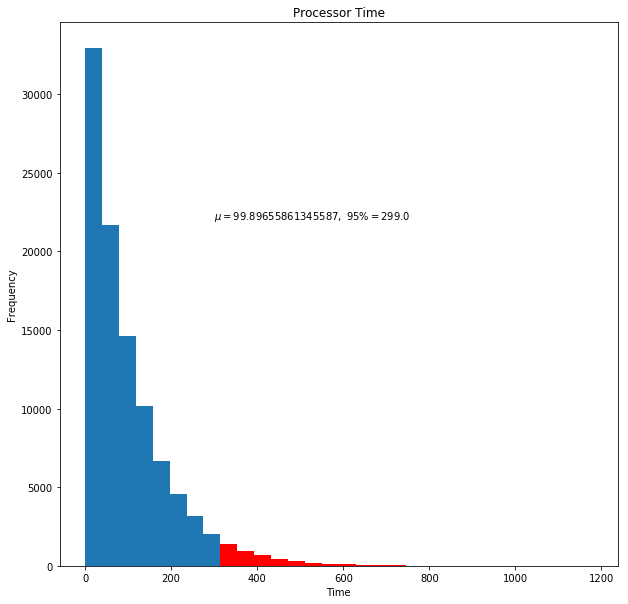

In [11]:
ds = data_source('m_m_1')

query= """select arr.load_id as load_id, arr.ts as ar_ts, dep.ts as dep_ts, dep.ts - arr.ts as proc_time from
 """+table_name+""" as arr join """+table_name+""" as dep on arr.load_id = dep.load_id
 where arr.ev_type = 'Start' and dep.ev_type = 'Complete' and dep.station_id = 'MM1_Simulation_Source' and arr.station_id = 'MM1_Simulation_Source'
 order by arr.ts asc"""

columns=['load_id', 'ar_ts', 'dep_ts', 'proc_time']

ev_str = ds.get_data_from_query(query, columns, indexes='load_id')

ds.close()

h = decorated_histogram('Processor Time', 'Time', ev_str['proc_time'])

df = ev_str['proc_time']

(df.mean(), df.std())



In [13]:
query= """select arr.evid as arr_id, arr.load_id as load_id, arr.ts as ar_ts from  """+table_name+""" as arr 
where arr.ev_type = 'Depart' and arr.station_id = 'MM1_Simulation_Source'
 order by arr.ts asc"""

columns=['arr_id','load_id', 'arr_ts']
ds = data_source('m_m_1')
ev_str = ds.get_data_from_query(query, columns, indexes='arr_id')
ds.close()

buckets200K = ev_str['arr_ts'].value_counts(normalize=False, sort=True, ascending=True, bins=50, dropna=True)

print({'min':buckets200K.min(), 'max':buckets200K.max(), 'mean':buckets200K.mean(), 'std':buckets200K.std()})

{'min': 1927, 'max': 2068, 'mean': 2002.1, 'std': 35.84219950430111}
